# Classification
A classification strategy is used when the tags are not **continuous**, but **categorical**. 

Decision Trees try to select features and values which split the dataset into positive and negative instances. The result is a tree where each node is either a decision node or a prediction node. Prediction nodes are leaf nodes and predict the label. Decision nodes cotain a condition and two child nodes one for when the condition is true and one for when the condition is false. 

![Decision Tree](images/dt.png "Decision Tree")  



## Classification Algorithms based on Decision Trees in Spark
- Decision Tree Classifier [link](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html#pyspark.ml.classification.DecisionTreeClassifier)
- Random Forest Classifier [link](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html#pyspark.ml.classification.RandomForestClassifier)
- Gradient Boosted Trees [link](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html#pyspark.ml.classification.GBTClassifier)

In [1]:
from pyspark.sql import SparkSession
spark =  SparkSession.builder.appName('TreeBasedClassification').getOrCreate()

df = spark.read.csv("titanic.csv", header=True, inferSchema=True)

df = df.select(['PassengerId',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Survived'])
df.show(10)
df = df.na.drop()
print(df.count())
df.groupBy('Survived').count().show()

+-----------+------+----+-----+-----+-------+--------+
|PassengerId|   Sex| Age|SibSp|Parch|   Fare|Survived|
+-----------+------+----+-----+-----+-------+--------+
|          1|  male|22.0|    1|    0|   7.25|       0|
|          2|female|38.0|    1|    0|71.2833|       1|
|          3|female|26.0|    0|    0|  7.925|       1|
|          4|female|35.0|    1|    0|   53.1|       1|
|          5|  male|35.0|    0|    0|   8.05|       0|
|          6|  male|NULL|    0|    0| 8.4583|       0|
|          7|  male|54.0|    0|    0|51.8625|       0|
|          8|  male| 2.0|    3|    1| 21.075|       0|
|          9|female|27.0|    0|    2|11.1333|       1|
|         10|female|14.0|    1|    0|30.0708|       1|
+-----------+------+----+-----+-----+-------+--------+
only showing top 10 rows

714
+--------+-----+
|Survived|count|
+--------+-----+
|       1|  290|
|       0|  424|
+--------+-----+



In [2]:
from pyspark.ml.feature import StringIndexer
si = StringIndexer(inputCol='Sex', outputCol='SexIndex')
si_fit = si.fit(df) # model pentru indexer

df_indexed = si_fit.transform(df)
df_indexed.show(10)

+-----------+------+----+-----+-----+-------+--------+--------+
|PassengerId|   Sex| Age|SibSp|Parch|   Fare|Survived|SexIndex|
+-----------+------+----+-----+-----+-------+--------+--------+
|          1|  male|22.0|    1|    0|   7.25|       0|     0.0|
|          2|female|38.0|    1|    0|71.2833|       1|     1.0|
|          3|female|26.0|    0|    0|  7.925|       1|     1.0|
|          4|female|35.0|    1|    0|   53.1|       1|     1.0|
|          5|  male|35.0|    0|    0|   8.05|       0|     0.0|
|          7|  male|54.0|    0|    0|51.8625|       0|     0.0|
|          8|  male| 2.0|    3|    1| 21.075|       0|     0.0|
|          9|female|27.0|    0|    2|11.1333|       1|     1.0|
|         10|female|14.0|    1|    0|30.0708|       1|     1.0|
|         11|female| 4.0|    1|    1|   16.7|       1|     1.0|
+-----------+------+----+-----+-----+-------+--------+--------+
only showing top 10 rows



In [3]:
from pyspark.ml.feature import VectorAssembler
inputCols=['SexIndex', 'Age', 'SibSp', 'Parch', 'Fare']
assembler_index = VectorAssembler(inputCols=inputCols, outputCol='features')

In [4]:
data = assembler_index.transform(df_indexed)

In [5]:
data.orderBy('Age').show(5, truncate=False)

+-----------+------+----+-----+-----+-------+--------+--------+--------------------------+
|PassengerId|Sex   |Age |SibSp|Parch|Fare   |Survived|SexIndex|features                  |
+-----------+------+----+-----+-----+-------+--------+--------+--------------------------+
|804        |male  |0.42|0    |1    |8.5167 |1       |0.0     |[0.0,0.42,0.0,1.0,8.5167] |
|756        |male  |0.67|1    |1    |14.5   |1       |0.0     |[0.0,0.67,1.0,1.0,14.5]   |
|470        |female|0.75|2    |1    |19.2583|1       |1.0     |[1.0,0.75,2.0,1.0,19.2583]|
|645        |female|0.75|2    |1    |19.2583|1       |1.0     |[1.0,0.75,2.0,1.0,19.2583]|
|79         |male  |0.83|0    |2    |29.0   |1       |0.0     |[0.0,0.83,0.0,2.0,29.0]   |
+-----------+------+----+-----+-----+-------+--------+--------+--------------------------+
only showing top 5 rows



In [21]:
train_df, test_df = data.randomSplit([0.7, 0.3], seed=12345)
train_df.groupBy('Survived').count().show()
test_df.groupBy('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  205|
|       0|  309|
+--------+-----+

+--------+-----+
|Survived|count|
+--------+-----+
|       1|   85|
|       0|  115|
+--------+-----+



In [7]:
from pyspark.ml.classification import DecisionTreeClassifier

dtc = DecisionTreeClassifier(labelCol='Survived', seed=42, maxDepth=3)
dtc_model = dtc.fit(train_df)

### Feature importances
Machine Learning models based on Decision Trees estimate the importance of each feature used for training. 

In [8]:
dtc_model.featureImportances

SparseVector(5, {0: 0.6963, 1: 0.1064, 3: 0.044, 4: 0.1532})

The following snippet retrieves the feature importances and sorts them by importance. Finally, it plots them using horizontal bars. 

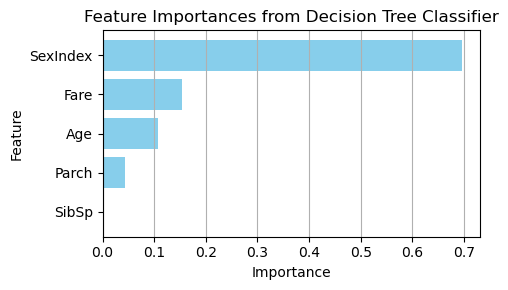

In [9]:
import matplotlib.pyplot as plt

# Retrieve feature importances
feature_importances = dtc_model.featureImportances.toArray()
feature_names = assembler_index.getInputCols()

# Create a list of tuples (feature, importance) and sort by importance
feature_importance_pairs = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Separate the sorted pairs into lists for plotting
sorted_features, sorted_importances = zip(*feature_importance_pairs)

# Plot the feature importances
plt.figure(figsize=(5, 3))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree Classifier')
plt.gca().invert_yaxis()  # To display the most important features on top
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### Debug String
Models based on Decision Trees have another parameter named *toDebugString*. This can be used to print all the nodes in the Decision Tree, as presented below. If the tree needs to be investigated visually, the content of the debug string must be parsed and the tree should be created using a tool like networkX. 

In [10]:

print("Decision Tree Model Structure:\n")
print(dtc_model.toDebugString)

Decision Tree Model Structure:

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_61d84d460cbc, depth=3, numNodes=11, numClasses=2, numFeatures=5
  If (feature 0 in {0.0})
   If (feature 4 <= 25.9646)
    If (feature 1 <= 11.5)
     Predict: 1.0
    Else (feature 1 > 11.5)
     Predict: 0.0
   Else (feature 4 > 25.9646)
    Predict: 0.0
  Else (feature 0 not in {0.0})
   If (feature 4 <= 49.5021)
    If (feature 3 <= 2.5)
     Predict: 1.0
    Else (feature 3 > 2.5)
     Predict: 0.0
   Else (feature 4 > 49.5021)
    Predict: 1.0



## Comparison of models based on Decision Trees

The following functions train and evaluate the models based on Decision Trees from Spark. 
The first function fits each of the three models to the dataset and then returns a list of tuples (name, model). 

The second function uses binary and multi-class evaluators to assess the performance of each algorithm.  

In [11]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

def train_models(train_df, labelCol='label'):
    dtc = DecisionTreeClassifier(labelCol=labelCol, seed=42)
    rfc = RandomForestClassifier(numTrees=30, labelCol=labelCol, seed=42)
    gbtc = GBTClassifier(labelCol=labelCol, seed=42)

    alg_names = ['Decision Tree', 'Random Forest', 'Gradient Boosted Trees']
    algs = [dtc, rfc, gbtc]

    models = []
    for alg, name in zip(algs, alg_names):
        model = alg.fit(train_df)
        models.append((name, model))

    return models

def evaluate_models(models, test_df, labelCol='label'):
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=labelCol)
    bin_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol=labelCol)

    metrics = {'Algorithm': [], 'Accuracy': [], 'ROC_AUC': [], 'PR_AUC': [], 'TP Rate': [], 'TN Rate': []}

    for name, model in models:
        pred = model.transform(test_df)

        roc = bin_eval.evaluate(pred, {bin_eval.metricName: "areaUnderROC"})
        auPR = bin_eval.evaluate(pred, {bin_eval.metricName: "areaUnderPR"})
        accuracy = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
        tpByLabel = evaluator.evaluate(pred, {evaluator.metricName: "truePositiveRateByLabel", evaluator.metricLabel: 1.0})
        tnByLabel = evaluator.evaluate(pred, {evaluator.metricName: "truePositiveRateByLabel", evaluator.metricLabel: 0.0})

        metrics['Algorithm'].append(name)
        metrics['Accuracy'].append(accuracy)
        metrics['ROC_AUC'].append(roc)
        metrics['PR_AUC'].append(auPR)
        metrics['TP Rate'].append(tpByLabel)
        metrics['TN Rate'].append(tnByLabel)

    return metrics

The following function receives the models trained at the previous step and the names of the features and plots the feature importances for each algorithm. 

In [12]:
import numpy as np
def plot_feature_importances(models, feature_names):
    feature_importances_data = {'Algorithm': []}

    for name, model in models:
        feature_importances = model.featureImportances.toArray()
        feature_importances_data['Algorithm'].append(name)
        feature_importances_data[name] = feature_importances

     # Plot feature importances
    fig_feature, ax_feature = plt.subplots(figsize=(10, 6))

    x_offset = np.arange(len(feature_names))  # The label locations for the x-axis
    width_feature = 0.25  # The width of the bars

    for name in feature_importances_data['Algorithm']:
        offset = (feature_importances_data['Algorithm'].index(name) - len(feature_importances_data['Algorithm']) / 2) * width_feature
        feature_importances = feature_importances_data[name]
        x_current = x_offset + offset
        ax_feature.bar(x_current, feature_importances, width_feature, label=name)

    ax_feature.set_xlabel('Feature')
    ax_feature.set_ylabel('Importance')
    ax_feature.set_title('Feature Importances')
    ax_feature.set_xticks(x_offset)
    ax_feature.set_xticklabels(feature_names, rotation=45, ha='right')
    ax_feature.legend()
    ax_feature.grid(axis='y')

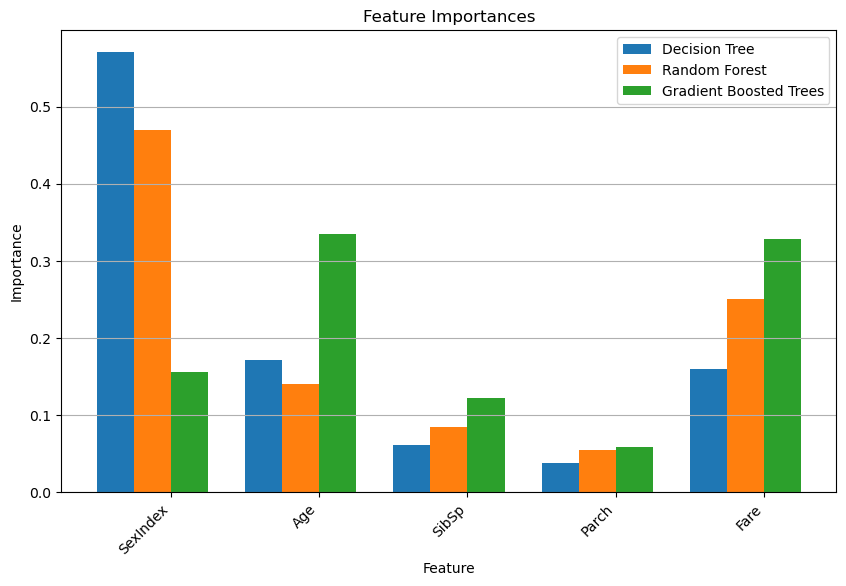

In [13]:
models = train_models(train_df, labelCol='Survived')
plot_feature_importances(models, inputCols)

The following function receives as argument the evaluation metrics computed by the second function and plots them for each algorithm. 

In [14]:
import numpy as np
def plot_results(metrics):
   

    # Plot evaluation metrics
    fig_metrics, ax_metrics = plt.subplots(figsize=(10, 5))

    metric_names = ['Accuracy', 'ROC_AUC', 'PR_AUC', 'TP Rate', 'TN Rate']
    x_metrics = np.arange(len(metric_names))  # The label locations
    width_metrics = 0.25  # The width of the bars

    for name in metrics['Algorithm']:
        offset = (metrics['Algorithm'].index(name) - len(metrics['Algorithm']) / 2) * width_metrics + width_metrics / 2
        alg_scores = [metrics[metric][metrics['Algorithm'].index(name)] for metric in metric_names]
        ax_metrics.bar(x_metrics + offset, alg_scores, width_metrics, label=name)

    ax_metrics.set_xlabel('Metric')
    ax_metrics.set_ylabel('Score')
    ax_metrics.set_title('Algorithm Performance Across Metrics')
    ax_metrics.set_xticks(x_metrics)
    ax_metrics.set_xticklabels(metric_names)
    ax_metrics.legend(title='Algorithm', loc='center left', bbox_to_anchor=(1, 0.5))
    ax_metrics.grid(axis='y')

    plt.tight_layout()
    plt.show()


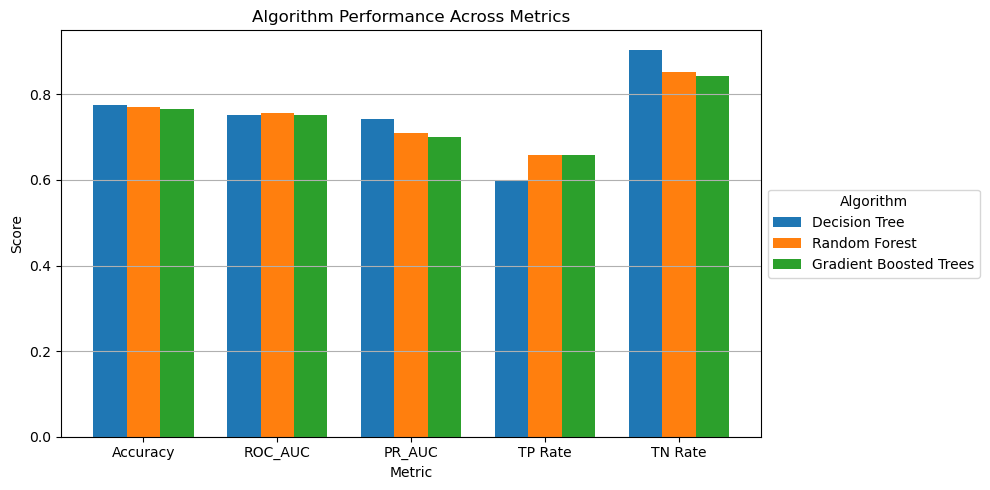

{'Algorithm': ['Decision Tree', 'Random Forest', 'Gradient Boosted Trees'], 'Accuracy': [0.775, 0.77, 0.765], 'ROC_AUC': [0.7521739130434782, 0.7554987212276214, 0.7511508951406649], 'PR_AUC': [0.7430645161290322, 0.7087610797743755, 0.7001629570747219], 'TP Rate': [0.6, 0.6588235294117647, 0.6588235294117647], 'TN Rate': [0.9043478260869565, 0.8521739130434782, 0.8434782608695652]}


In [15]:
metrics = evaluate_models(models, test_df, labelCol='Survived')
plot_results(metrics)
print(metrics)

## Cross Validation

Cross Validation is a technique used to evaluate the performance of a machine learning model by dividing the dataset into multiple folds. Each fold serves as a testing set while the remaining folds are used for training. This is useful for estimating how well a model will generalize to an unseen dataset.

### Steps
1. Splitting Data: The dataset is split into 'k' subsets, or folds. The value of 'k' is usually 3, 5, or 10, depending on the data size and the desired computation time.
2. Training and Validation: For each fold:
    - A model is trained on the remaining 'k-1' folds.
    - The model is validated (tested) using the fold that was held out.
    - The performance metric (e.g., accuracy, F1-score) is computed for each fold.
3. Aggregating Results: The performance metrics from all folds are averaged to provide a more robust evaluation of the model's expected performance.

### Key Benefits:
1. Bias-Variance Trade-off: Reduces bias by training on multiple data subsets and evaluating on various test sets.
2. Model Selection: Helps in selecting the best model configuration (hyperparameters).
3. Robust Evaluation: Provides a more comprehensive understanding of how the model will perform on unseen data.

In [16]:
def k_fold_experiment(train_df, labelCol='label', num_folds=5):
    # Define models
    models = []

    dtc = DecisionTreeClassifier(labelCol=labelCol, seed=42)
    paramGrid_dtc = ParamGridBuilder() \
        .addGrid(dtc.maxDepth, [5, 10, 15]) \
        .build()
    models.append((dtc, paramGrid_dtc))

    rfc = RandomForestClassifier(labelCol=labelCol, seed=42)
    paramGrid_rfc = ParamGridBuilder() \
        .addGrid(rfc.numTrees, [20, 30, 40]) \
        .addGrid(rfc.maxDepth, [5, 10, 15]) \
        .build()
    models.append((rfc, paramGrid_rfc))

    gbtc = GBTClassifier(labelCol=labelCol, seed=42)
    paramGrid_gbtc = ParamGridBuilder() \
        .addGrid(gbtc.maxIter, [10, 20, 30]) \
        .addGrid(gbtc.maxDepth, [5, 10, 15]) \
        .build()
    models.append((gbtc, paramGrid_gbtc))

    trained_models = []
    for model, paramGrid in models:
        crossval = CrossValidator(estimator=model,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Survived'),
                                  numFolds=num_folds)
        cv_model = crossval.fit(train_df)
        
        best_model = cv_model.bestModel
        
        # Extract the parameters from the ParamGrid
        best_params = {}
        for param in paramGrid[0].keys():
            best_params[param.name] = best_model.getOrDefault(param)
        
        param_summary = '_'.join([f"{param}_{value}" for param, value in best_params.items()])
        best_model_name = f"{type(model).__name__}_{param_summary}"
        trained_models.append((best_model_name, best_model))

    return trained_models


Total time for cross-validation training: 99.09384655952454 seconds


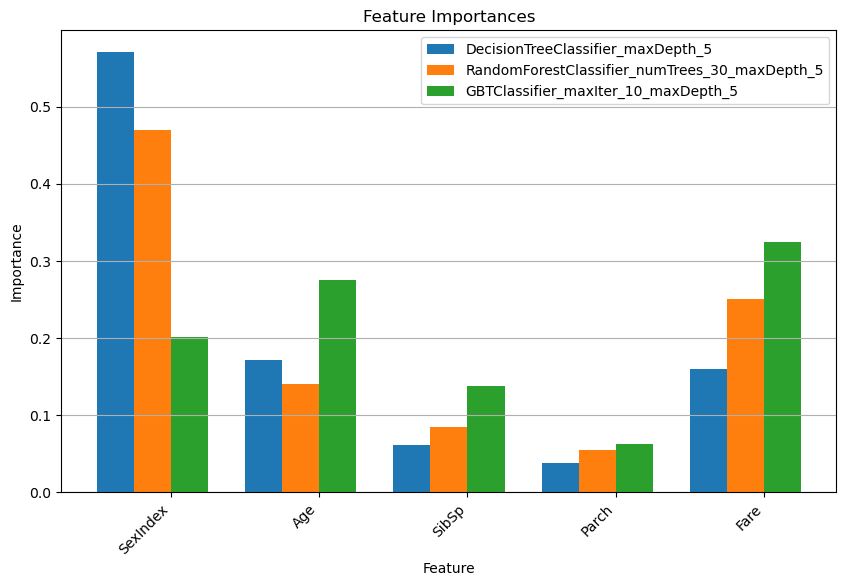

In [17]:
import time
start = time.time()
models = k_fold_experiment(train_df, labelCol='Survived', num_folds=2)
end = time.time()
total = end - start
print("Total time for cross-validation training:", total, "seconds")
plot_feature_importances(models, inputCols)

{'Algorithm': ['DecisionTreeClassifier_maxDepth_5', 'RandomForestClassifier_numTrees_30_maxDepth_5', 'GBTClassifier_maxIter_10_maxDepth_5'], 'Accuracy': [0.775, 0.77, 0.75], 'ROC_AUC': [0.7521739130434782, 0.7554987212276214, 0.7396419437340153], 'PR_AUC': [0.7430645161290322, 0.7087610797743755, 0.6726805658972449], 'TP Rate': [0.6, 0.6588235294117647, 0.6705882352941176], 'TN Rate': [0.9043478260869565, 0.8521739130434782, 0.808695652173913]}


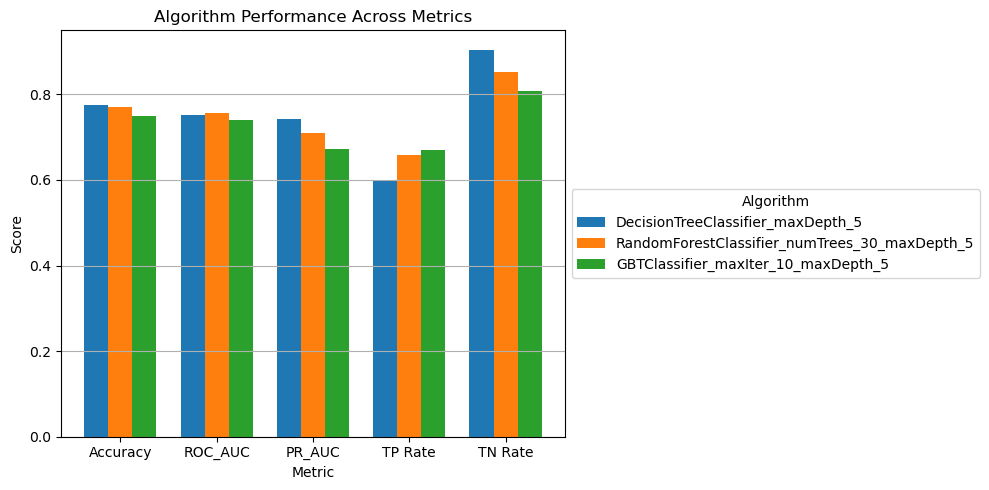

In [18]:
metrics = evaluate_models(models, test_df, labelCol='Survived')
print(metrics)
plot_results(metrics)

Total time for cross-validation (10-fold) training: 485.3246202468872 seconds
{'Algorithm': ['DecisionTreeClassifier_maxDepth_5', 'RandomForestClassifier_numTrees_20_maxDepth_10', 'GBTClassifier_maxIter_20_maxDepth_5'], 'Accuracy': [0.775, 0.76, 0.765], 'ROC_AUC': [0.7521739130434782, 0.7391304347826088, 0.7511508951406649], 'PR_AUC': [0.7430645161290322, 0.7126923076923076, 0.7001629570747219], 'TP Rate': [0.6, 0.6, 0.6588235294117647], 'TN Rate': [0.9043478260869565, 0.8782608695652174, 0.8434782608695652]}


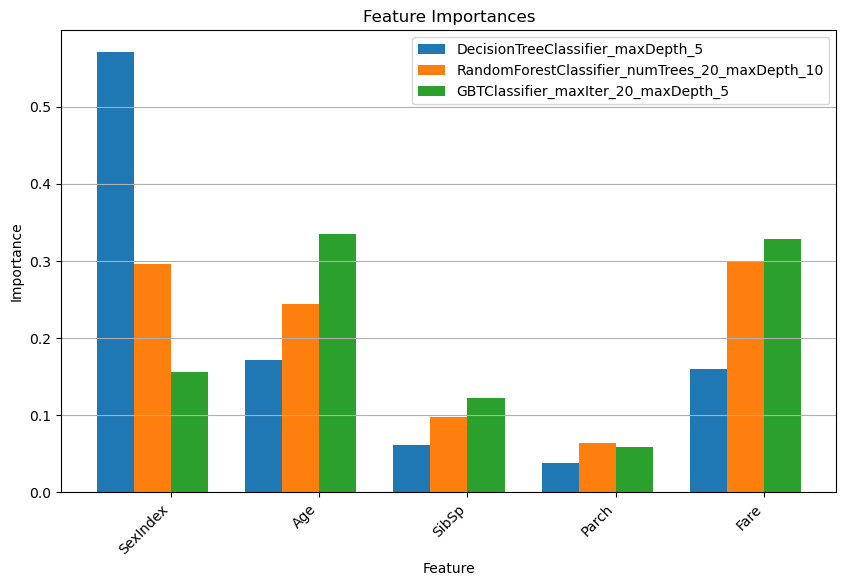

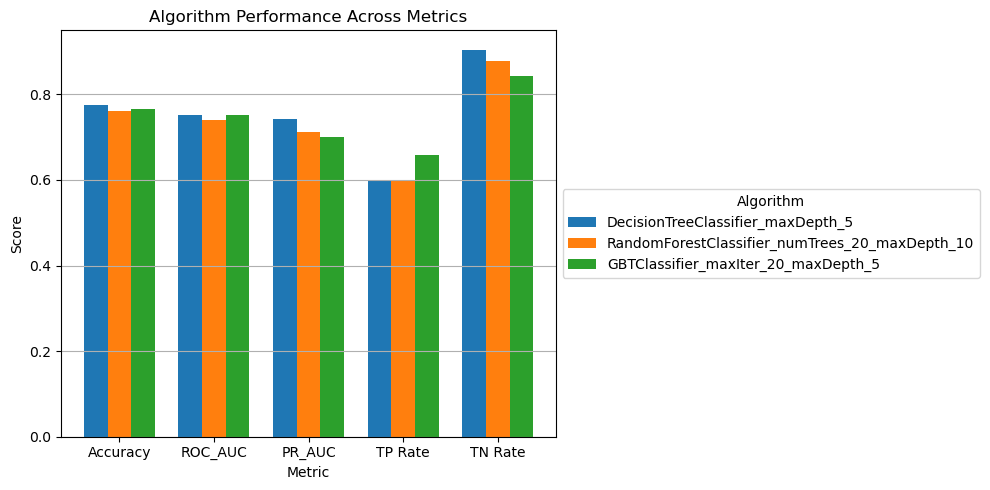

In [19]:

start = time.time()
models = k_fold_experiment(train_df, labelCol='Survived', num_folds=10)
end = time.time()
total = end - start
print("Total time for cross-validation (10-fold) training:", total, "seconds")
plot_feature_importances(models, inputCols)
metrics = evaluate_models(models, test_df, labelCol='Survived')
print(metrics)
plot_results(metrics)